In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

In [2]:
metro_df = pd.read_pickle('../Data/all_metro_data.pkl')

In [3]:
#forward fill missing values for each metro to reduce NaN values
metro_df = pd.concat([metro_df['metro_id'], metro_df.groupby('metro_id').ffill()], axis=1)

In [4]:
metro_df 

,metro_id,metro_name,state_id,state_name,period,year,month,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,...,metro_pct_blw_list,metro_pct_w_pricecut,metro_rent,state_hvi,state_personal_income,state_personal_income_per_capita,state_population,state_gdp_cur_dol,state_job_openings,state_job_openings_szn_adjd
0,394297,"Aberdeen, SD",SD,South Dakota,2009-02-28,2009,2,NaN,128414.895204,NaN,...,NaN,NaN,NaN,147638.885390,NaN,NaN,NaN,NaN,8.0,9.0
1,394297,"Aberdeen, SD",SD,South Dakota,2009-03-31,2009,3,NaN,128428.614787,NaN,...,NaN,NaN,NaN,147559.476539,31406.1,NaN,NaN,NaN,7.0,7.0
2,394297,"Aberdeen, SD",SD,South Dakota,2009-04-30,2009,4,NaN,128232.347262,NaN,...,NaN,NaN,NaN,147229.826738,31406.1,NaN,NaN,NaN,8.0,8.0
3,394297,"Aberdeen, SD",SD,South Dakota,2009-05-31,2009,5,NaN,128120.247626,NaN,...,NaN,NaN,NaN,146863.651913,31406.1,NaN,NaN,NaN,10.0,9.0
4,394297,"Aberdeen, SD",SD,South Dakota,2009-06-30,2009,6,NaN,127924.063926,NaN,...,NaN,NaN,NaN,146483.638609,31711.7,NaN,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212452,845172,"Winfield, KS",KS,Kansas,2023-11-30,2023,11,154.0,NaN,NaN,...,NaN,0.267385,NaN,222566.236372,189073.4,64276.0,2941593.0,64276.0,83.0,87.0
212453,845172,"Winfield, KS",KS,Kansas,2023-12-31,2023,12,146.0,NaN,NaN,...,NaN,0.215387,NaN,222324.630758,190108.6,64591.0,2943265.0,64591.0,77.0,85.0
212454,845172,"Winfield, KS",KS,Kansas,2024-01-31,2024,1,136.0,NaN,NaN,...,NaN,0.194851,NaN,222197.238452,190108.6,64591.0,2943265.0,64591.0,77.0,85.0
212455,845172,"Winfield, KS",KS,Kansas,2024-02-29,2024,2,130.0,NaN,NaN,...,NaN,0.186402,NaN,222731.307862,190108.6,64591.0,2943265.0,64591.0,77.0,85.0


In [5]:
metro_df = metro_df.dropna(subset='metro_hvi')

# Create lag features, normalize numeric data and split into train/test datasets

In [6]:
#Create lag features for trends
y_cols = ['metro_id','metro_hvi','state_hvi']
X_cols = ['metro_id', 'metro_for_sale_inventory', 'metro_hvi', 'metro_med_days_to_close', 
          'metro_new_construct', 'metro_new_listing', 'metro_pct_abv_list', 'metro_pct_blw_list', 
          'metro_pct_w_pricecut', 'metro_rent', 'state_hvi', 'state_personal_income',
          'state_personal_income_per_capita', 'state_population', 'state_gdp_cur_dol', 'state_job_openings', 'state_job_openings_szn_adjd']

def add_lag_features(df, fwrd_lag=[1,2,3,4,6,7], prev_lag=[1,4,7,12]):
    global y_new_cols
    global X_new_cols
    y_new_cols = []
    X_new_cols = []
    
    for lag in fwrd_lag:

        #Add hvi values for future periods to be used as target variable
        df = df.sort_values(by=['metro_id','state_id','period'])
        y_shifted_cols = ["frwd"+str(lag).zfill(2)+"_mon_"+col for col in y_cols]
        y_new_cols.extend(y_shifted_cols)

        df[y_shifted_cols] = df[y_cols].shift(-lag) #create forward looking columns
        df.loc[metro_df[y_cols[0]] != df[y_shifted_cols[0]],y_shifted_cols[1:3]] = np.nan #set new numeric columns as null if metro_id doesn't match
        df = df.drop(columns=[y_shifted_cols[0]]) #drop metro_id duplicate column

        #Create column with percentage change from the lag period
        for i, col in enumerate(y_shifted_cols):
            if 'metro_id' in col:
                pass
            else:
                old_col = y_cols[i]
                new_col_nm = col+"_pct_chg"
                df[new_col_nm] = (df[col] / df[old_col]) - 1
                y_new_cols.extend([new_col_nm])

    #Add incremental changes from previous periods
    for lag in prev_lag:
        X_shifted_cols = ["prev"+str(lag).zfill(2)+"_mon_"+col for col in X_cols]
        X_new_cols.extend(X_shifted_cols)

        df[X_shifted_cols] = df[X_cols].shift(lag) #create backward looking columns
        df.loc[metro_df[X_cols[0]] != df[X_shifted_cols[0]],X_shifted_cols[1:3]] = np.nan #set new numeric columns as null if metro_id doesn't match
        df = df.drop(columns=[X_shifted_cols[0]]) #drop metro_id duplicate column

        #Create column with percentage change from the lag period
        for i, col in enumerate(X_shifted_cols):
            if 'metro_id' in col:
                pass
            else:
                old_col = X_cols[i]
                new_col_nm = col+"_pct_chg"
                df[new_col_nm] = (df[old_col] / df[col]) - 1
                X_new_cols.extend([new_col_nm])
    
    y_new_cols = [col for col in y_new_cols if 'metro_id' not in col] 
    X_new_cols = [col for col in X_new_cols if 'metro_id' not in col]
    return_cols = ['metro_id', 'period'] + X_new_cols + y_new_cols
    return(df[return_cols])

In [7]:
scaler = MinMaxScaler()

def train_normalizer(df, scaler=scaler):
    #Seperate columns into types for reshaping of data
    orig_columns = list(df.columns)
    metro_columns = orig_columns[:4] + ['variable']
    non_numeric_features = orig_columns[:7]
    
    #reshape data so periods are each a seperate columns
    df_reshaped = pd.melt(df, id_vars=non_numeric_features)
    df_reshaped = df_reshaped.pivot(index=metro_columns,
                                    columns='period',
                                    values='value')

    #Forward fill data
    #For periods with missing data, fill with the previous value available. If no early data available, leave null.
    df_reshaped = df_reshaped.ffill(axis=1)
    
    #Normalize all numeric data to retain variance but range from 0 to 1
    scaler.fit(df_reshaped.T)

In [8]:
def normalize_data(df, scaler=scaler):
    #Seperate columns into types for reshaping of data
    orig_columns = list(df.columns)
    merge_columns = orig_columns[:4] + ['period']
    metro_columns = orig_columns[:4] + ['variable']
    period_columns = orig_columns[4:7]
    numeric_features = orig_columns[7:]
    non_numeric_features = orig_columns[:7]
    
    #reshape data so periods are each a seperate columns
    df_reshaped = pd.melt(df, 
                          id_vars=non_numeric_features)
    df_reshaped = df_reshaped.pivot(index=metro_columns,
                                    columns='period',
                                    values='value')

    #Forward fill data
    #For periods with missing data, fill with the previous value available. If no early data available, leave null.
    df_reshaped = df_reshaped.ffill(axis=1)
    
    #Reshape filled data back to original format
    df_unshaped = pd.melt(df_reshaped.reset_index(), 
                          id_vars=metro_columns)
    df_unshaped = df_unshaped.pivot(index=merge_columns,
                                    columns='variable',
                                    values='value')

    
    #Normalize all numeric data to retain variance but range from 0 to 1
    data_normalized = scaler.transform(df_reshaped.T)
    df_normalized = pd.DataFrame(data_normalized.T, 
                                 index=df_reshaped.index, 
                                 columns=df_reshaped.columns
                                ).reset_index()

    #Reshape back to original format with normalized data
    df_normalized = pd.melt(df_normalized,
                            id_vars=metro_columns)
    df_normalized = df_normalized.pivot(index=merge_columns,
                                        columns='variable',
                                        values='value'
                                       ).add_suffix('_normalized')
    
    #Add normalized data to original dataframe as seperate columns
    df_final = df_unshaped.merge(df_normalized, 
                                 on=merge_columns, 
                                 how='right'
                                ).reset_index()
    
    #Clean up year and month columns
    df_final.insert(5,'month',df_final['period'].dt.month)
    df_final.insert(5,'year',df_final['period'].dt.year)
    return(df_final)

In [9]:
#Create dataframe with lag features
metro_df_lag_features = add_lag_features(metro_df)

C:\Users\Brendan\AppData\Local\Temp\ipykernel_41188\1245947706.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_nm] = (df[old_col] / df[col]) - 1
C:\Users\Brendan\AppData\Local\Temp\ipykernel_41188\1245947706.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_nm] = (df[old_col] / df[col]) - 1
C:\Users\Brendan\AppData\Local\Temp\ipykernel_41188\1245947706.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [10]:
#Create datasets for time series split cross-validation

#Sample 1 (Train: 2018-2019.6 | Test: 2019.7 - 2020.6) 1 of 5 years (20%)
#Sample 2 (Train: 2018-2020.6 | Test: 2020.7 - 2021.6) 1 of 5 years (20%)
#Sample 3 (Train: 2018-2021.6 | Test: 2021.7 - 2022.6) 1 of 5 years (20%)
#Validation (Train: 2018-2022.6 | Test: 2022.7 - 2023) 1.5 of 5 years (30%)

sample_groups = ['metro_samp_1','metro_samp_2','metro_samp_3','metro_samp_val']
sample_train = [sample + '_train' for sample in sample_groups]
sample_test = [sample + '_test' for sample in sample_groups]
train_start_date = ['2018-01-01'] * 4
train_end_date = ['2019-07-01','2020-07-01','2021-07-01','2022-07-01']
test_start_date = train_end_date
test_end_date = ['2020-07-01','2021-07-01','2022-07-01','2024-01-01']

sample_dfs = {}
for i, df_name in enumerate(sample_groups):
    df = metro_df[(metro_df.period >= train_start_date[i]) &
                  (metro_df.period <= test_end_date[i])]

    sample_dfs[df_name] = df
    
    df_train_name = df_name + '_train'
    df_train = df[(df.period >= train_start_date[i]) &
                  (df.period <= train_end_date[i])]
    sample_dfs[df_train_name] = df_train

    df_test_name = df_name + '_test'
    df_test = df[(df.period >= test_start_date[i]) &
                 (df.period <= test_end_date[i]) &
                 (df.metro_id.isin(df_train.metro_id))] #exclude any metro id's that are not in the training dataset
    sample_dfs[df_test_name] = df_test

In [11]:
#Normalize all datasets and add lag features
for i, df_name in enumerate(sample_groups):
    #train normalizer
    df_train_name = df_name + '_train'
    df_train_name_normalized = df_train_name + '_normalized'
    train_normalizer(sample_dfs[df_train_name])
    
    #normalize training data
    df_train_normalized = normalize_data(sample_dfs[df_train_name])
    df_train_normalized = df_train_normalized.merge(metro_df_lag_features, on=['metro_id','period'], how='left')
    sample_dfs[df_train_name_normalized] = df_train_normalized
    
    #normalize test data
    df_test_name = df_name + '_test'
    df_test_name_normalized = df_test_name + '_normalized'
    df_test_normalized = normalize_data(sample_dfs[df_test_name])
    df_test_normalized = df_test_normalized.merge(metro_df_lag_features, on=['metro_id','period'], how='left')
    sample_dfs[df_test_name_normalized] = df_test_normalized

C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\prepr

# Cluster metro areas

In [12]:
#Set features for clustering
kmeans_features = ['metro_id',
                   'metro_name',
                   'period',
                   'metro_hvi',
                   'prev12_mon_metro_hvi_pct_chg',
                   'metro_new_construct',
                   'prev12_mon_metro_rent_pct_chg',
                   'state_hvi', 
                   'state_job_openings', 
                   'state_personal_income',
                   'state_population']

#Drop records with missing data
kmeans_df = sample_dfs['metro_samp_val_train_normalized'][kmeans_features].dropna().copy()
kmeans_data_clean = np.array(kmeans_df[kmeans_features[3:]])

#Standardize data to have consistent mean and variance for each feature
standardizer = StandardScaler()
standardizer.fit(kmeans_data_clean)
kmeans_data_standardized = standardizer.transform(kmeans_data_clean)

#use kmeans model to find 5 buckets for metro id's using key features identified during EDA 
kmeans = KMeans(n_clusters=5, random_state=0)
metro_clusters = kmeans.fit_predict(kmeans_data_standardized)

#create dictionary to lookup cluster for each metro_id
kmeans_df['cluster'] = metro_clusters
metro_clusters_df = kmeans_df.groupby(['metro_id','metro_name']).cluster.value_counts(normalize=True).reset_index().drop_duplicates(subset=['metro_id'])
metro_clusters_dict = metro_clusters_df.set_index('metro_id')['cluster'].to_dict()

C:\Users\Brendan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
#Add dummy columns for clusters from kmeans
for sample_df in sample_dfs:
    #Remove old clusters (if rerunning)
    cols = sample_dfs[sample_df].columns
    drop_cols = [col for col in cols if 'cluster' in col]
    
    #Add clusters and generate dummy columns
    sample_dfs[sample_df] = sample_dfs[sample_df].drop(columns=drop_cols)
    sample_dfs[sample_df]['cluster'] = sample_dfs[sample_df]['metro_id'].map(metro_clusters_dict).fillna(5).astype('int') #add 6th cluster for missing metros
    if sample_df == 'metro_samp_val_train_normalized':
        metro_clusters_viz_df = sample_dfs[sample_df]
    sample_dfs[sample_df] = pd.get_dummies(sample_dfs[sample_df],columns=['cluster'], drop_first=True)

In [14]:
metro_clusters_viz_df

,metro_id,metro_name,state_id,state_name,period,year,month,metro_for_sale_inventory,metro_hvi,metro_med_days_to_close,...,frwd04_mon_state_hvi_pct_chg,frwd06_mon_metro_hvi,frwd06_mon_state_hvi,frwd06_mon_metro_hvi_pct_chg,frwd06_mon_state_hvi_pct_chg,frwd07_mon_metro_hvi,frwd07_mon_state_hvi,frwd07_mon_metro_hvi_pct_chg,frwd07_mon_state_hvi_pct_chg,cluster
0,394297,"Aberdeen, SD",SD,South Dakota,2018-01-31,2018,1,NaN,154172.905655,NaN,...,0.016320,156689.276756,196281.525642,0.016322,0.023020,157018.337079,196935.204843,0.018456,0.026427,5
1,394297,"Aberdeen, SD",SD,South Dakota,2018-02-28,2018,2,NaN,154538.720740,NaN,...,0.016067,157018.337079,196935.204843,0.016045,0.023490,157189.033595,197672.695099,0.017150,0.027323,5
2,394297,"Aberdeen, SD",SD,South Dakota,2018-03-31,2018,3,184.0,155225.918108,NaN,...,0.015703,157189.033595,197672.695099,0.012647,0.022902,156970.670454,198030.479157,0.011240,0.024753,5
3,394297,"Aberdeen, SD",SD,South Dakota,2018-04-30,2018,4,200.0,155541.602780,NaN,...,0.014712,156970.670454,198030.479157,0.009188,0.020355,157100.274302,198595.616920,0.010021,0.023267,5
4,394297,"Aberdeen, SD",SD,South Dakota,2018-05-31,2018,5,226.0,155875.006350,NaN,...,0.013727,157100.274302,198595.616920,0.007861,0.018460,157427.132329,199322.920692,0.009958,0.022190,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48271,753929,"Zapata, TX",TX,Texas,2022-02-28,2022,2,38.0,141262.159358,NaN,...,0.078459,142268.308039,311237.115280,0.007123,0.091857,140343.344480,310567.773229,-0.006504,0.089509,5
48272,753929,"Zapata, TX",TX,Texas,2022-03-31,2022,3,43.0,140076.410995,NaN,...,0.065637,140343.344480,310567.773229,0.001906,0.066487,138155.104481,309597.332425,-0.013716,0.063155,5
48273,753929,"Zapata, TX",TX,Texas,2022-04-30,2022,4,43.0,138783.331739,NaN,...,0.047328,138155.104481,309597.332425,-0.004527,0.041810,134909.927164,308563.830018,-0.027910,0.038332,5
48274,753929,"Zapata, TX",TX,Texas,2022-05-31,2022,5,42.0,138874.697512,NaN,...,0.026175,134909.927164,308563.830018,-0.028549,0.019553,131218.236819,307238.519665,-0.055132,0.015174,5


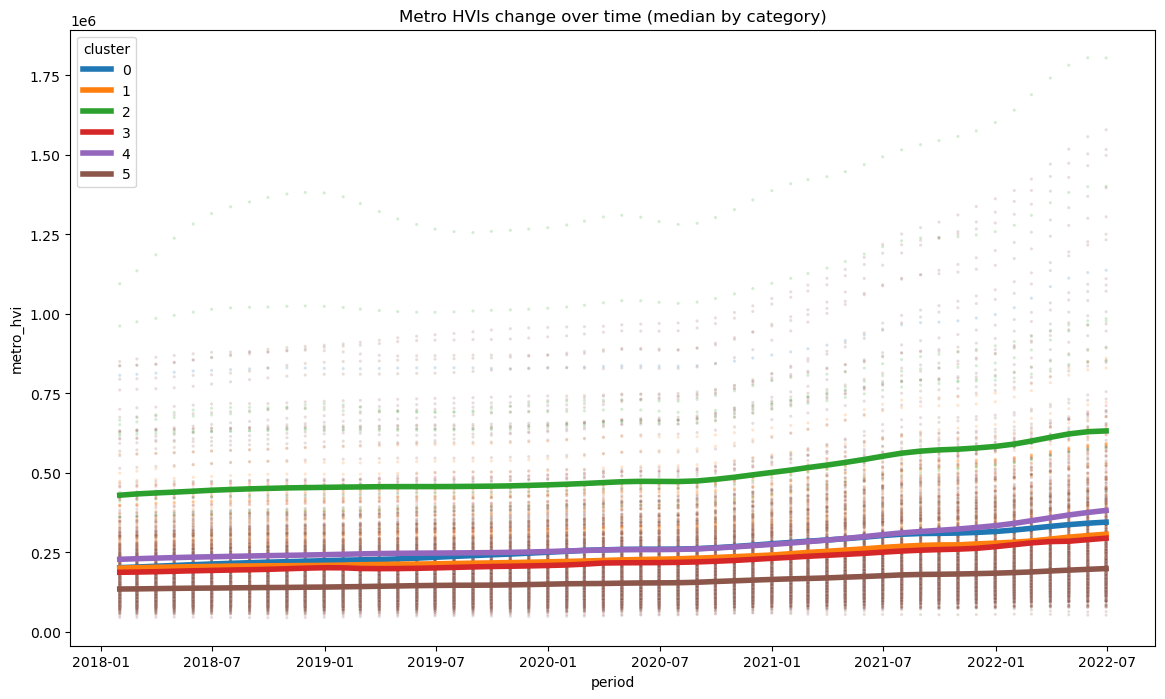

In [15]:
fig, ax = plt.subplots(figsize=(14,8))
x='period'
y='metro_hvi'
hue='cluster'
metro_clusters_viz_df['cluster'] = metro_clusters_viz_df['cluster'].astype('str') 
metro_clusters_viz_df = metro_clusters_viz_df.sort_values('cluster')
sns.scatterplot(data=metro_clusters_viz_df, x=x, y=y, hue=hue, s=5, alpha=.2, ax=ax, legend=False)
sns.lineplot(data=metro_clusters_viz_df.groupby([x,hue]).agg({y:'median'}), x=x, y=y, hue=hue, linewidth=4, ax=ax)
plt.title('Metro HVIs change over time (median by category)')
plt.show()

# Export all train/test datasets

In [16]:
#Pickle the dictionary of DataFrames to a file
with open('../Data/test_train_datasets.pkl', 'wb') as f:
    pickle.dump(sample_dfs, f)  # 'wb' for writing in binary mode